In [52]:
import yfinance as yf
import pandas as pd
import numpy as np
import random
random.seed(42)
import mplfinance as mpf
from multiprocessing import Pool

In [8]:
data = yf.download("AAPL",start="2015-1-1",end="2019-12-31",interval="1d")

/home/jupyter/.cache/pypoetry/virtualenvs/compare-multiple-backtests-2J6ybkfi-py3.10/lib/python3.10/site-packages/yfinance/utils.py:775: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
[*********************100%%**********************]  1 of 1 completed


In [9]:
df = data.copy()


,Open,High,Low,Close,Adj Close,Volume,Return
Date,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.435266,212818400,NaN
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.746891,257142000,-0.028172
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.749126,263188400,0.000094
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.082138,160423600,0.014022
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.007431,237458000,0.038422
...,...,...,...,...,...,...,...
2019-12-23,70.132500,71.062500,70.092499,71.000000,69.082329,98572000,0.016318
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.148010,48478800,0.000951
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.519920,93121200,0.019840


/home/jupyter/.cache/pypoetry/virtualenvs/compare-multiple-backtests-2J6ybkfi-py3.10/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


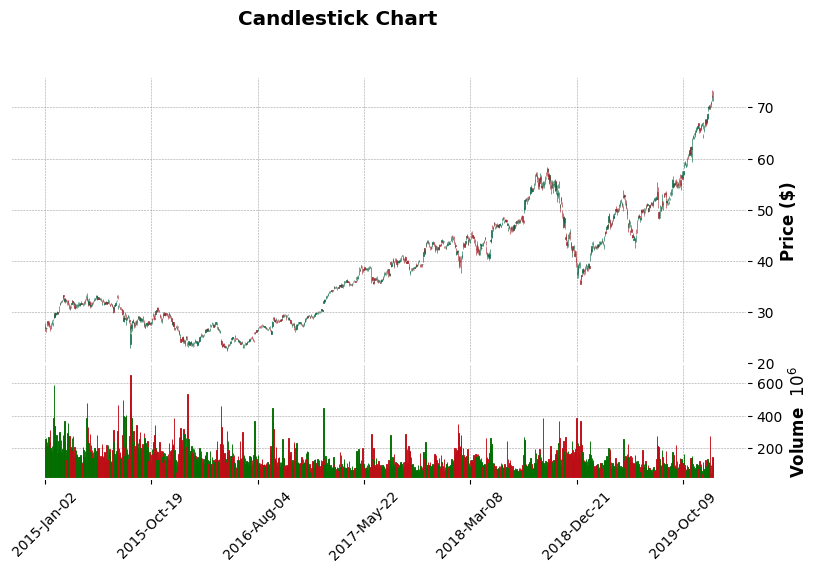

In [10]:
mpf.plot(df, type='candle', style='charles',
         title='Candlestick Chart',
         ylabel='Price ($)',
         figratio=(16, 9),
         volume=True)

In [19]:
df = df.assign(Return=lambda x: x.Close.pct_change()).dropna()

In [21]:
def initialize_population(size, gene_length):
    return [[random.choice([-1, 0, 1]) for _ in range(gene_length)] for _ in range(size)]


In [38]:
def calculate_annualized_fitness(individual, price_changes):
    # Calculate daily returns based on trading actions
    daily_returns = [action * change for action, change in zip(individual, price_changes)]
    
    # Calculate the average daily return and standard deviation of daily returns
    avg_daily_return = np.mean(daily_returns)
    std_dev_returns = np.std(daily_returns)
    
    # Assuming no risk-free rate for simplicity; subtract risk-free rate from avg_daily_return if available
    if std_dev_returns > 0:
        daily_sharpe_ratio = avg_daily_return / std_dev_returns
    else:
        daily_sharpe_ratio = 0  # To handle division by zero if std_dev_returns is 0
    
    # Annualize the Sharpe Ratio
    annualized_sharpe_ratio = daily_sharpe_ratio * np.sqrt(252)
    
    return annualized_sharpe_ratio

In [39]:
def select_parents(population, fitnesses, num_parents):
    parents = sorted(zip(population, fitnesses), key=lambda x: x[1], reverse=True)
    return [parent for parent, _ in parents[:num_parents]]


In [40]:
def crossover(parents, offspring_size):
    offspring = []
    crossover_point = random.randint(1, offspring_size - 1)
    for _ in range(offspring_size):
        parent1, parent2 = random.sample(parents, 2)
        child = parent1[:crossover_point] + parent2[crossover_point:]
        offspring.append(child)
    return offspring


In [59]:
def mutate(offspring, mutation_rate=0.3):
    for individual in offspring:
        if random.random() < mutation_rate:
            mutation_point = random.randint(0, len(individual) - 1)
            individual[mutation_point] = random.choice([-1, 0, 1])
    return offspring


In [62]:
def run_genetic_algorithm(price_changes, generations=50, population_size=100000, gene_length=100, num_parents=300):
    population = initialize_population(population_size, gene_length)
    for generation in range(generations):
        fitnesses = [calculate_fitness(individual, price_changes) for individual in population]
        parents = select_parents(population, fitnesses, num_parents)
        offspring = crossover(parents, offspring_size=len(population) - len(parents))
        offspring = mutate(offspring)
        population = parents + offspring
        print(f"Generation {generation + 1}, Best Fitness: {max(fitnesses)}")

    best_index = fitnesses.index(max(fitnesses))
    return population[best_index]

# Running the GA with our sample data
best_strategy = run_genetic_algorithm(df["Return"], generations=2000, population_size=1000, gene_length=df.shape[0], num_parents=200)
print("Best Trading Strategy:", best_strategy)


Generation 1, Best Fitness: 0.10098538610323503
Generation 2, Best Fitness: 0.10540478487074169
Generation 3, Best Fitness: 0.13529417614586609
Generation 4, Best Fitness: 0.14853977143261785
Generation 5, Best Fitness: 0.15618129874590467
Generation 6, Best Fitness: 0.1642971058125907
Generation 7, Best Fitness: 0.17845833003815254
Generation 8, Best Fitness: 0.17960750814933416
Generation 9, Best Fitness: 0.1819264257711567
Generation 10, Best Fitness: 0.18865579312597883
Generation 11, Best Fitness: 0.1946407182495131
Generation 12, Best Fitness: 0.19479282707140974
Generation 13, Best Fitness: 0.20632730563207335
Generation 14, Best Fitness: 0.20726203302150023
Generation 15, Best Fitness: 0.21131474342782475
Generation 16, Best Fitness: 0.21536348823563944
Generation 17, Best Fitness: 0.2168479988594131
Generation 18, Best Fitness: 0.22060579916768663
Generation 19, Best Fitness: 0.2218059371553093
Generation 20, Best Fitness: 0.22301692509274954
Generation 21, Best Fitness: 0.225

In [ ]:
def cumsum(lst):
    total = 0
    cumsum_list = []
    for num in lst:
        total += num
        cumsum_list.append(total)
    return cumsum_list

In [ ]:
cumsum_returns = cumsum(daily_returns)

In [ ]:
cumsum_returns